In [ ]:
'''
AIM

Develop a machine learning program to identify when an article might be fake news. 

train.csv: A full training dataset with the following attributes:
•	id: unique id for a news article
•	title: the title of a news article
•	author: author of the news article
•	text: the text of the article; could be incomplete
•	label: a label that marks the article as potentially unreliable
o	1: unreliable
o	0: reliable
test.csv: A testing training dataset with all the same attributes at train.csv without the label.

'''

'\nDevelop a machine learning program to identify when an article might be fake news. \n\ntrain.csv: A full training dataset with the following attributes:\n•\tid: unique id for a news article\n•\ttitle: the title of a news article\n•\tauthor: author of the news article\n•\ttext: the text of the article; could be incomplete\n•\tlabel: a label that marks the article as potentially unreliable\no\t1: unreliable\no\t0: reliable\ntest.csv: A testing training dataset with all the same attributes at train.csv without the label.\n\n'

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data

In [ ]:
# read dataframe from csv file
df = pd.read_csv("train.csv")

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# null value handling
df = df.fillna('')

# create new column with title and author name in one line
df["total"] = df['title'] + " " + df["author"]

df.head()

,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [ ]:
# seperating target column from input features 
X = df.drop("label", axis = 1)
y = df["label"]

X.shape, y.shape

((20800, 5), (20800,))

## Pre-Processing

In [ ]:
VOCAB_SIZE = 5000
text = X.copy()

In [ ]:
# function to clean and normalize words in text
# PorterStemmer - removing the commoner morphological and inflexional endings 
def text_cleaning(length):
    ps = PorterStemmer()
    corpus = []
    for i in range(length):
        # sentence beginning with alphabets
        m = re.sub("[^a-zA-Z]"," ",text["total"][i])
        # toggle to lowercase
        m = m.lower()
        # break sentence into words
        m = m.split()
        # porterstem all the words which add meaning to the sentence and store them in the same variable
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        # cleaned words joined back as a sentence (albeit not one that makes sense)
        clean_text = " ".join(m)
        # join sentence back to the text block
        corpus.append(clean_text)
        
    return corpus

In [ ]:
# print the time taken to do the above function
%%time
clean_text_corpus = text_cleaning(len(text))

CPU times: user 46.5 s, sys: 4.66 s, total: 51.2 s
Wall time: 55.7 s


In [ ]:
# check 1st line of cleaned text
clean_text_corpus[0]

'hous dem aid even see comey letter jason chaffetz tweet darrel lucu'

In [ ]:
# one hot encode 1000(VOCAB_SIZE) words in the cleaned text 
onehot_text = [one_hot(words, VOCAB_SIZE) for words in clean_text_corpus]

In [ ]:
# padding sequences to same length
padded_doc = pad_sequences(onehot_text, padding="pre", maxlen = 25)

In [ ]:
# training data is pre-processed now
x_train = np.array(padded_doc)
y_train = np.array(y)

## Model

In [ ]:
def build_model():
    # model structure
    model = tf.keras.Sequential([
        # vectorize words
        L.Embedding(VOCAB_SIZE, 40, input_length = 25),
        # to prevent overfitting
        L.Dropout(0.3),
        # rnn based layer with feedback connections 
        L.LSTM(100),
        # anti-overfitting
        L.Dropout(0.3),
        # define size of output to 64 and use relu act. f(x) (to prevent exponential growth)
        L.Dense(64, activation = "relu"),
        # same as above
        L.Dropout(0.3),
        # define size of output to 1 and use sigmoid act. f(x) (for mapping predicted values to probabilities)
        L.Dense(1, activation = "sigmoid")
    ])
    
    # compile model using adam optimizer (for faster computation time and requirement of fewer parameter for tuning)
    # loss function is binary cross-entropy function (good for when prediction only have 0, 1 values)
    # metrics calculated using binary accuracy function
    model.compile(optimizer="adam", loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), # non-normalized losses
                 metrics = tf.metrics.BinaryAccuracy()
                 )
    
    return model

In [ ]:
news_classifier = build_model()
news_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

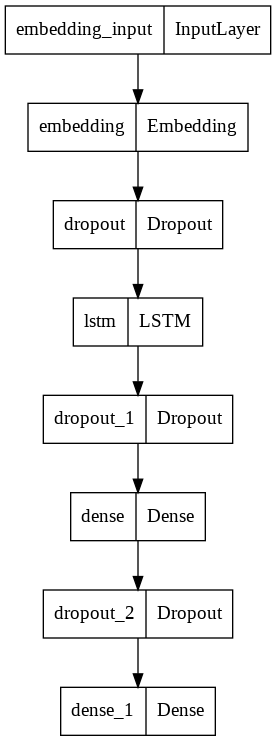

In [ ]:
tf.keras.utils.plot_model(news_classifier)

## Training

In [ ]:
## for logging model stats ##
my_callbacks = [tf.keras.callbacks.ModelCheckpoint("news_classifier.h5", monitor = "val_loss", save_best_only=True),
                tf.keras.callbacks.CSVLogger("training.log"),
                tf.keras.callbacks.EarlyStopping(patience=5),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
               ]

In [ ]:
# training model for 25 epochs
history = news_classifier.fit(
    x_train,
    y_train,
    epochs = 25,
    batch_size = 128,
    validation_split = 0.2,
    callbacks = my_callbacks
)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


130/130 [==============================] - 11s 67ms/step - loss: 0.2656 - binary_accuracy: 0.8776 - val_loss: 0.0428 - val_binary_accuracy: 0.9868 - lr: 0.0010
Epoch 2/25
130/130 [==============================] - 8s 63ms/step - loss: 0.0300 - binary_accuracy: 0.9903 - val_loss: 0.0328 - val_binary_accuracy: 0.9897 - lr: 0.0010
Epoch 3/25
130/130 [==============================] - 8s 63ms/step - loss: 0.0130 - binary_accuracy: 0.9964 - val_loss: 0.0363 - val_binary_accuracy: 0.9906 - lr: 0.0010
Epoch 4/25
130/130 [==============================] - 8s 63ms/step - loss: 0.0072 - binary_accuracy: 0.9981 - val_loss: 0.0481 - val_binary_accuracy: 0.9904 - lr: 0.0010
Epoch 5/25
130/130 [==============================] - 8s 62ms/step - loss: 0.0031 - binary_accuracy: 0.9995 - val_loss: 0.0455 - val_binary_accuracy: 0.9904 - lr: 0.0010
Epoch 6/25
130/130 [==============================] - 8s 62ms/step - loss: 0.0023 - binary_accuracy: 0.9993 - val_loss: 0.0516 - val_binary_accuracy: 0.9901 - l

## Making Predictions

In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
# null value handling
test_df = test_df.fillna('')
# make new column with title and author name in one line
test_df["total"] = test_df["title"] + " " + test_df["author"]

text_test = test_df.copy()

# same function used in preprocessing just defined again
def text_cleaning_test(length):
    ps = PorterStemmer()
    corpus_test = []
    for i in range(length):
        m = re.sub("[^a-zA-Z]"," ",text_test["total"][i])
        m = m.lower()
        m = m.split()
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus_test.append(clean_text)
        
    return corpus_test

clean_test_corpus = text_cleaning_test(len(text_test))

# one hot encode 1000(VOCAB_SIZE) words
onehot_text_test = [one_hot(words, VOCAB_SIZE) for words in clean_test_corpus]

# padding sequences to the fixed length of 25
padded_doc_test = pad_sequences(onehot_text_test, padding="pre", maxlen = 25)

# append cleaned text back to the test data variable
x_test = np.array(padded_doc_test)

In [ ]:
# making predictions
predictions = news_classifier.predict(x_test)

# converting float predictions to int
predictions = [int(np.round(pred[0])) for pred in predictions]

###### rough

In [ ]:
# visualization will done sometime later

In [ ]:
###########################################################################################
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from numpy import mean

rf_a = accuracy_score(y_test,y_rf)
rf_p, rf_r, rf_f1,_ = precision_recall_fscore_support(y_test,y_rf)
rf_scores = [rf_a,mean(rf_p),mean(rf_r),mean(rf_f1)]

ind = np.arange(len(rf_scores))
width = 0.27

ax = plt.figure().add_subplot(111)
rects1 = ax.bar(ind-(width/2), rf_scores, width, color='g')
rects2 = ax.bar(ind+(width/2), bag_scores, width, color='r')

ax.set_xticks(ind)
ax.set_xticklabels(['Accuracy','Precision','Recall','F1 Score'])
ax.legend((rects1[0], rects2[0]), ('Training', 'Testing'),loc='center')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%.2f'%h, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [ ]:
'''
2 dl classifications

after pre-prop do word embedding

XG boosting
svm

for i in arr:
	arr[i] = arr[i]/max(arr)
'''

In [ ]:
#########################################################################################################
# Also check the values in confusion matrix.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')

cm = confusion_matrix(y_test, y_rf, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(ax=axes[0])
disp.ax_.set_title('Random Forest Classifier')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('True')

cm = confusion_matrix(y_test, y_bag, labels=best_bag.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_bag.classes_)
disp.plot(ax=axes[1])
disp.ax_.set_title('Bagging Classifier')
disp.ax_.set_xlabel('')
disp.ax_.set_ylabel('')

f.text(0.5, 0, 'Predicted', ha='left')
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit()